## Setup

In [1]:
import torch
print(torch.__version__)
#import torchvision
#import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec

from data_loader import get_train_val_loader, get_test_loader
from autoencoder_helpers import *
from modules import *

#GPU/CUDA setup
if torch.cuda.is_available():
    print("CUDA enabled!")
    device = torch.device('cuda:0')  # You can specify the index of the CUDA device you want to use
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Specify the index of the GPU(s) you want to use
else:
    print("CUDA not available. Using CPU.")
    device = torch.device('cpu')
    
data_folder = 'data'
batch_size = 250
n_workers = 0
random_seed = 0

# download MNIST data
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)

1.9.0+cu102


C:\Users\jiras\AppData\Local\Temp\ipykernel_10312\5412540.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


CUDA enabled!


# Test and look inside the model on MNIST data

Load the model

In [5]:
paths = {"B30": "saved_model\mnist_model\mnist_cae_balanced_clstsep_1500_0.002_250_True_0.0_20_1_1_1_1.0_0.0_30_4_32_1\mnist_cae00750.pth",
         "S30": "saved_model\mnist_model\mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_30_4_32_1\mnist_cae00750.pth",
         "S15": "saved_model\mnist_model\mnist_cae_standard_default_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_15_4_32_1\mnist_cae00750.pth",
         "RS30": "saved_model\mnist_model\mnist_cae_adversarial_standard_default_pdglinf_ce_20_0.3_0.02_True_1500_0.002_250_False_0.5_20_1_1_1_0.8_0.2_1.0_30_4_32_1\mnist_cae_adv00750.pth",
         "RB30": "saved_model\mnist_model\mnist_cae_adversarial_balanced_clstsep_pdglinf_ce_20_0.3_0.02_True_800_0.002_250_True_0.0_20_1_1_1_1.0_0.0_1.0_30_4_32_1\mnist_cae_adv00750.pth",
         "FTB30n": "saved_model\mnist_model\mnist_cae_FT_30_nothing_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1\mnist_cae_adv00020.pth",
         "FTB30a": "saved_model\mnist_model\mnist_cae_FT_30_autoencoder_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1\mnist_cae_adv00020.pth",
         "FTB30p": "saved_model\mnist_model\mnist_cae_FT_30_prototypes_pdglinf_ce_20_0.3_0.02_True_20_0.002_250_20_1_1_1_1.0_0.0_1\mnist_cae_adv00020.pth"}

s15 = torch.load(paths["S15"])
s30 = torch.load(paths["S30"])
b30 = torch.load(paths["B30"])
rs30 = torch.load(paths["RS30"])
rb30 = torch.load(paths["RB30"])
ftb30n = torch.load(paths["FTB30n"])
ftb30a = torch.load(paths["FTB30a"])
ftb30p = torch.load(paths["FTB30p"])

s15.to(device)
s30.to(device)
b30.to(device)
rs30.to(device)
rb30.to(device)
ftb30a.to(device)
ftb30n.to(device)
ftb30p.to(device)

print("MODELS LOADED")

MODELS LOADED


In [6]:
model = b30

In [7]:
n_classes = model.fc.linear.weight.size(0)
n_prototypes = model.fc.linear.weight.size(1)
input_height = 28         # MNIST data input shape
input_width = input_height

Show model prototypes

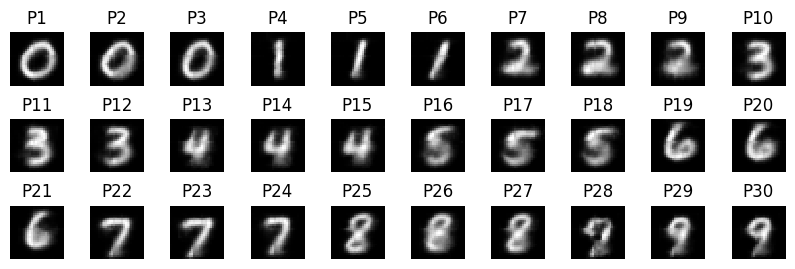

In [8]:
# visualize the prototype images
prototype_distances = model.prototype_layer.prototype_distances
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

n_cols = 10
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))

# Ajuste del espacio entre subgráficos
plt.subplots_adjust(wspace=0.5, hspace=0.5)

for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            b[i][j].axis('off')
            b[i][j].set_title(f'P{i*n_cols + j + 1}')
plt.show()

Decoding

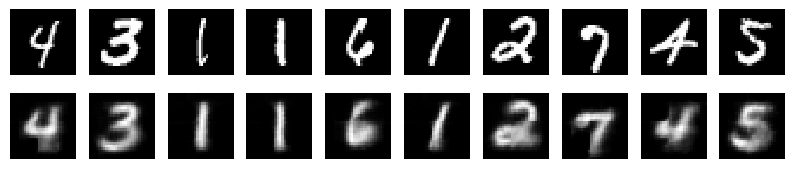

In [9]:
# Apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10

encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()

# Compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                   cmap='gray',
                   interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                   cmap='gray',
                   interpolation='none')
    a[1][i].axis('off')
                
plt.show()

Show model fc weights

In [10]:
rows = [f"P{i+1}" for i in range(n_prototypes)]
transposed_weights = model.fc.linear.weight.T.cpu().detach().numpy()    
df_weights = pd.DataFrame(transposed_weights, columns=range(n_classes), index=rows)

# Find the minimum value of each row
min_values = df_weights.min(axis=1)

# Highlight the minimum values in red
def highlight_min(s):
    is_min = s == s.min()
    return ['color: red' if v else '' for v in is_min]

# Apply the highlight_min function to the DataFrame
df_highlighted = df_weights.style.apply(highlight_min, axis=1)

df_highlighted


,0,1,2,3,4,5,6,7,8,9
P1,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P2,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P3,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P4,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P5,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P6,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P7,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P8,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P9,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
P10,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
